In [1]:
import torch 
import torch.nn as nn
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

#for loading data
from io import open
import glob
import os

In [2]:
class SimpleSignal(torch.utils.data.Dataset):
    def __init__(self, N=1000, T=100):
        super(SimpleSignal, self).__init__()
        self.N = N
        self.T = T
        self.data, self.labels = self.generate_data()
        self.train_ix, self.test_ix = self.get_ix_splits()
    
    def __getitem__(self, ix):
        return self.data[ix], self.labels[ix]
    
    def __len__(self):
        return len(self.data)

    def get_ix_splits(self):
        split_props = [0.8, 0.1, 0.1] # Train/validation/test split proportions
        indices = range(len(self.data))
        split_points = [int(len(self.data)*i) for i in split_props]
        train_ix = np.random.choice(indices,
                                    split_points[0],
                                    replace=False)
        test_ix = np.random.choice((list(set(indices)-set(train_ix))),
                                    split_points[1],
                                    replace=False)
        return train_ix, test_ix

    def generate_data(self):
        def findFiles(path): return glob.glob(path)
        
        data, labels = [], []
        for filename in findFiles('/Users/klind/Documents/Python Scripts/WPI Data Science REU/data\\ItalyPowerDemand_TRAIN'):
            lines_vector=[]
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for i in range(len(lines)):
                line = np.asarray(lines[i].split(','))
                line_clean = []
                for j in line:
                    elem = float(j)
                    line_clean.append(elem)
                label = np.asarray(line_clean.pop(0))
                if (label==2.0):
                    label=1.0
                else:
                    label=0.0
                data.append(line_clean)
                labels.append(label)
        for filename in findFiles('/Users/klind/Documents/Python Scripts/WPI Data Science REU/data\\ItalyPowerDemand_TEST'):
            lines_vector=[]
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for i in range(len(lines)):
                line = np.asarray(lines[i].split(','))
                line_clean = []
                for j in line:
                    elem = float(j)
                    line_clean.append(elem)
                label = np.asarray(line_clean.pop(0))
                if (label==2.0):
                    label=1.0
                else:
                    label=0.0
                data.append(line_clean)
                labels.append(label)
        
        data_array = np.asarray(data)
        labels_array = np.asarray(labels)
        data_tensor = torch.tensor(data_array, dtype=torch.float).unsqueeze(2)
        labels_tensor = torch.tensor(labels_array, dtype=torch.long)
        #print(data_tensor)
        #print(labels_tensor)
        return data_tensor, labels_tensor

In [18]:
HIDDEN_DIMENSION_vector = [20, 40]  #num of hid dim2 will be same as in hid dim1 i.e. if hid_dim1=20, hid_dim2=20
N_LAYERS = 1
BATCH_SIZE = 10
N_EPOCHS = 28 #initially 20
LEARNING_RATE = [.01, .001, .0001]
SEQ_LENGTH = 10     #of data
N_INSTANCES = 1000  #of data
N_FEATURES = 1      #dimensions of each input?
N_CLASSES = 2       #dimensions of each output?

# --- create the dataset ---
data = SimpleSignal(T=SEQ_LENGTH, N=N_INSTANCES)
#for i in range(data.N):
    #print(data.data[i], data.labels[i])

In [19]:
# --- define the data loaders ---
train_sampler = SubsetRandomSampler(data.train_ix) # Random sampler for training indices
test_sampler = SubsetRandomSampler(data.test_ix) # Random sampler for testing indices

train_loader = torch.utils.data.DataLoader(dataset=data,
                                           batch_size=BATCH_SIZE, 
                                           sampler=train_sampler,
                                           shuffle=False,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=data,
                                          batch_size=BATCH_SIZE, 
                                          sampler=test_sampler,
                                          shuffle=False,
                                          drop_last=True)

# --- define your model here ---
class RNN(nn.Module):
    def __init__(self, HIDDEN_DIMENSION, N_CLASSES, N_FEATURES, N_LAYERS, BATCH_SIZE):
        super(RNN, self).__init__()
        self.N_LAYERS = N_LAYERS
        self.BATCH_SIZE = BATCH_SIZE
        self.HIDDEN_DIMENSION = HIDDEN_DIMENSION
        self.N_CLASSES = N_CLASSES
        
        HIDDEN_DIMENSION1, HIDDEN_DIMENSION2 = HIDDEN_DIMENSION, HIDDEN_DIMENSION
        
        # --- define mappings here ---
        self.lstm1 = torch.nn.LSTM(N_FEATURES, HIDDEN_DIMENSION1)       #sets up initial weight matrices
        self.lstm2 = torch.nn.LSTM(HIDDEN_DIMENSION1, HIDDEN_DIMENSION2)
        self.out = torch.nn.Linear(HIDDEN_DIMENSION2, N_CLASSES)
        #nonlinear part - tells probabilites
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, X):  #X is input data - tensor shape = (batch size, input dimension)
        # --- define forward pass here ---
        #initialize hidden state - need to do this because this is an RNN/LSTM (you use torch.nn.LSTM above)
        state = (torch.zeros(N_LAYERS, BATCH_SIZE, HIDDEN_DIMENSION), # h_0 initial hidden state
                 torch.zeros(N_LAYERS, BATCH_SIZE, HIDDEN_DIMENSION)) # c_0 initial cell state
        X = torch.transpose(X, 0, 1)  #should have shape timesteps, batch_size, num features
        
        hidden, state = self.lstm1(X, state)   #X is timeseries, shape is (timesteps, batch size)
        hidden, state = self.lstm2(hidden, state)
        #hidden = h_t = hidden cell sate after w1 weight matrix (self.LSTM has been applied to the current cell) = this is actually vector containing all h_t's for each cell
        #state = (h_n, c_n) = h_n is hidden state that depends on all previous cells, c_n is cell state that depends on all previous cells
        output = self.out(hidden[-1])   #cell's hidden state gets passed thru w2 (out) weight matrix to produce output
        prediction = self.softmax(output)
        return prediction

In [20]:
loss_dif_lr = [] #loss vectors for (hid dim, lr) = {(20, .01), (20, .001), (20, .0001), (40, .01), (40, .001), (40, .001)}
accuracy_dif_lr = [] #accuracy vector for (hid dim, lr) like above
loss_testing_dif_lr=[]
accuracy_testing_dif_lr=[]

for i_hid_dim in range(len(HIDDEN_DIMENSION_vector)):
    HIDDEN_DIMENSION = HIDDEN_DIMENSION_vector[i_hid_dim]
    
    for i_lr in range(len(LEARNING_RATE)):
        # --- initialize the model and the optimizer ---
        model = RNN(HIDDEN_DIMENSION, N_CLASSES, N_FEATURES, N_LAYERS, BATCH_SIZE)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE[i_lr]) 
        # Using the Adam optimizer - don't worry about the details, it's going to update the network's weights.
        criterion = torch.nn.CrossEntropyLoss()   #definig loss function

        # --- training the model ---
        loss_vector_training=[]
        accuracy_vector_training=[]
        for epoch in range(N_EPOCHS):
            loss_sum = 0
            predictions_sum = 0
            labels_sum = 0
            for i, (time_series, labels) in enumerate(train_loader): # Iterate through the training batches
                # --- Forward pass ---
                predictions = model(time_series)   #time_series has to have shape (batch size=10, input dimension=1)

                # --- Compute gradients and update weights ---
                optimizer.zero_grad()   #zero gradients, can also do model.zero_grad() in this case

                for i in range(10):
                    predict = predictions[i,1]
                    if predict <=.5:
                        estimate=0
                    else:
                        estimate=1
                    if estimate==labels[i]:
                        predictions_sum += 1
                    labels_sum += 1
                loss = criterion(predictions, labels)    #predictions shape is (10, 2), labels shape is (10)
                loss.backward(retain_graph = True)
                optimizer.step()  #updates parameters using Adam alg rather than grad descent
                loss_sum += loss.item()
                #if (i+1) % 1 == 0:
                #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, N_EPOCHS, i+1, len(train_loader), loss.item()))
            accuracy = predictions_sum/labels_sum
            loss_total = loss_sum/87
            accuracy_vector_training.append(accuracy)
            loss_vector_training.append(loss_total)
            #print('accuracy: ', accuracy)
            #print ('Loss for each Epoch:','Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, N_EPOCHS, loss_total))

            #----testing----
        loss_vector_testing=[]
        accuracy_vector_testing=[]
        for i, (time_series, labels) in enumerate(test_loader): # Iterate through the testing set, 10 timeseries in 10 batches (100 timeseries total)
                predictions_sum = 0
                labels_sum = 0
                loss_sum = 0
                predictions = model(time_series)   #time_series has to have shape (batch size=10, input dimension=1)

                for i in range(10):
                    predict = predictions[i,1]
                    if predict <=.5:
                        estimate=0
                    else:
                        estimate=1
                    if estimate==labels[i]:
                        predictions_sum += 1
                    labels_sum += 1
                loss = criterion(predictions, labels)    #predictions shape is (10, 2), labels shape is (10)
                loss_sum += loss.item()
                accuracy = predictions_sum/labels_sum
                loss_vector_testing.append(loss_sum)
                accuracy_vector_testing.append(accuracy)

        #----keeping track of all losses and accuracies for each learning rate
        print('lr: ', LEARNING_RATE[i_lr], 'hid dim: ', HIDDEN_DIMENSION)
        loss_dif_lr.append(loss_vector_training)
        accuracy_dif_lr.append(accuracy_vector_training)
        loss_testing_dif_lr.append(loss_vector_testing)
        accuracy_testing_dif_lr.append(accuracy_vector_testing)
print(len(loss_dif_lr))

RuntimeError: Expected hidden[0] size (1, 10, 20), got (3, 10, 20)

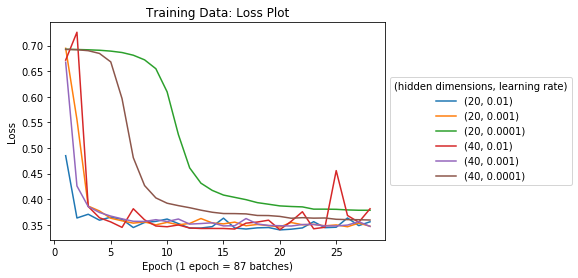

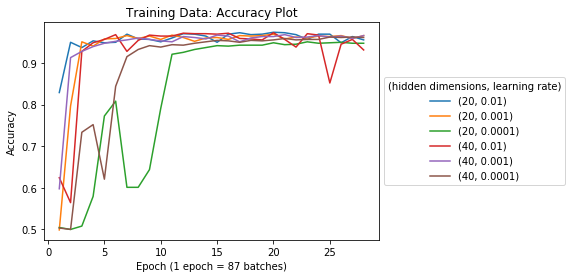

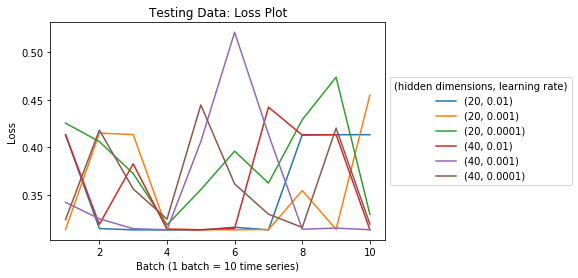

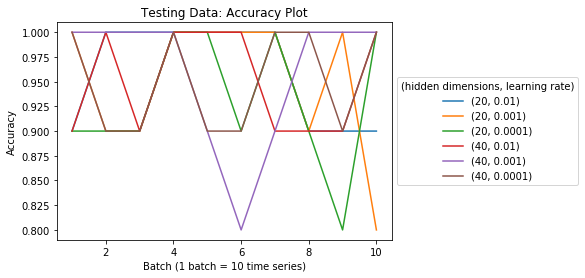

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

tuples_vector = []
for hid_dim in HIDDEN_DIMENSION_vector:
    for lr in LEARNING_RATE:
        tuples_vector.append( (hid_dim, lr))

epochs_vector = [i for i in range(1, N_EPOCHS+1)]
for dif_combo in loss_dif_lr:
    plt.plot(epochs_vector, dif_combo)
plt.legend([t for t in tuples_vector], loc='center left', bbox_to_anchor=(1, 0.5), title="(hidden dimensions, learning rate)")
plt.title('Training Data: Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch (1 epoch = 87 batches)')
plt.show()

for dif_combo in accuracy_dif_lr:
    plt.plot(epochs_vector, dif_combo)
plt.legend([t for t in tuples_vector], loc='center left', bbox_to_anchor=(1, 0.5), title="(hidden dimensions, learning rate)")
plt.title('Training Data: Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch (1 epoch = 87 batches)')
plt.show()

batch_vector = [i for i in range(1, 11)]
for dif_combo in loss_testing_dif_lr:
    plt.plot(batch_vector, dif_combo)
plt.legend([t for t in tuples_vector], loc='center left', bbox_to_anchor=(1, 0.5), title="(hidden dimensions, learning rate)")
plt.title('Testing Data: Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Batch (1 batch = 10 time series)')
#plt.axis([0, 10, .5, .8])
plt.show()

batch_vector = [i for i in range(1, 11)]
for dif_combo in accuracy_testing_dif_lr:
    plt.plot(batch_vector, dif_combo)
plt.legend([t for t in tuples_vector], loc='center left', bbox_to_anchor=(1, 0.5), title="(hidden dimensions, learning rate)")
plt.title('Testing Data: Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Batch (1 batch = 10 time series)')
#plt.axis([0, 10, 0, 1])
plt.show()

In [17]:
def truncate(n, decimals):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

print("{0:^80}".format('----- TESTING   DATA -----'))
print('(hidden dimensions, learning rate)      Average Accuracy              St Dev')
for i in range(len(tuples_vector)):
    print("{:^30s} {:^32f} {:^18f}".format('%s' %str(tuples_vector[i]),
                                     truncate(np.average(accuracy_testing_dif_lr[i]), 3), 
                                     truncate(np.std(accuracy_testing_dif_lr[i]), 4)  )) 


                           ----- TESTING   DATA -----                           
(hidden dimensions, learning rate)      Average Accuracy              St Dev
          (20, 0.01)                       0.960000                  0.048900     
         (20, 0.001)                       0.950000                  0.067000     
         (20, 0.0001)                      0.930000                  0.064000     
          (40, 0.01)                       0.950000                  0.049900     
         (40, 0.001)                       0.960000                  0.066300     
         (40, 0.0001)                      0.950000                  0.049900     


In [ ]:
#this is for 2 lstm layers